## Machine Learning Allocation

Lopez de Prado(2018)은 기존 Risk Parity 배분에 대한 개선책으로 계층적 리스크 패리티 배분을 제안하였다. 이번 실습에서는 계층적 리스크 패리티 배분에 대해서 다룬 뒤, 기존의 Markowitz 배분과 Inverse Variance 배분에 비해 어떤 특징들이 있는지 살펴보도록 한다

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

START_DATE = '2013-12-31'
END_DATE = pd.to_datetime('today')
TICKERS = [
    'SPY', # SPDR SPX index ETF
    'SCHD', # Schweb US Divident Equity ETF
    'VTV', # Vanguard value index fund ETF
    'GOVT', # iShares US Treasury Bond ETF
    'SOXX', # iShares Semiconductor ETF
    'GLD', # SPDR Gold trust
    'CPER', # US Copper Index Fund
    'IJR', # iShares Core S&P Small cap ETF
    'IJH', # iShares Core S&P Mid cap ETF
    'USO', # United States Oil Fund LP
    'JPY=X' # USD/JPY Currency
]

data = yf.download(
    TICKERS,
    start = START_DATE,
    end = END_DATE,
    interval = '1wk'
)['Adj Close']

[*********************100%%**********************]  11 of 11 completed


### Hierarchical Principal Components Analysis

계층적 PCA(Hierarchical PCA)는 대규모 또는 복잡한 데이터 세트를 효과적으로 분석하기 위한 방법이다. 이 접근법은 데이터를 여러 서브셋으로 분할한 후 각 서브셋에 대해 주성분 분석(PCA)을 별도로 수행한다

Subset별로 PCA를 통해 각 서브셋의 주요 패턴과 구조를 추출하며, 이후 이러한 결과를 종합하여 전체 데이터 세트의 특성을 파악한다. 계층적 PCA는 대규모 데이터 세트를 다루는 데 있어 계산상의 부담을 줄이고, 서브셋 간의 다양한 관계나 특성을 더 깊이 이해할 수 있다는 것이 장점이다 이 방법은 복잡한 구조를 가진 데이터 세트를 세분화하여 분석하는 데 특히 유용하며, 금융 분야에서 주로 쓰이고 있다. 그러나 계층적 PCA는 전체 데이터에 대한 일반적인 PCA와 다른 결과를 줄 가능성이 크기 때문에, 분석 결과 해석 시 데이터 분할 방식과 Subset의 특성을 모두 고려해야 한다

계층적 PCA에는 다음과 같은 단계로 이뤄진다

1. 트리 군집화
2. 준 대각화(Quasi-Diagonalization)
3. 재귀적 이분법

계층적 군집화를 통해 금융 시계열에서 자산의 배분이 어떻게 이루어지는지 보도록 한다

#### 트리 군집화

관측값 $X$의 $T \times N$행렬을 고려해 보자. 행렬은 $T$기간에 대한 $N$개 변수 계열이다. 이 $N$ 열벡터를 군집의 계층 구조로 병합해 배분을 트리 그래프를 따라 하향식으로 흘러내리고자 한다

첫째, 원소가 $\rho = \{\rho_{i,j}\}_{i,j = 1, \dots, N}$인 $N \times N$ 상관관계 행렬을 계산한다. 여기서 $\rho_{i,j} = \rho [X_i, X_j]$다. 거리 척도는 $d : (X_i, X_j) \subset B \rightarrow \mathbb{R} \in [0,1], d_{i,j} = d[X_i, X_j] = \sqrt{\frac{1}{2}(1 - \rho_{i,j})}$로 정의되며, 여기서 $B = [1,\dots, i, \dots, N]$내의 원소의 카티시안 곱이다. 이는 $N \times N$ 거리 행렬 $D = \{d_{i,j}\}_{i,j = 1, \dots, N}$을 계산할 수 있게 해준다. 행렬 $D$는 다음과 같은 성질을 갖는다

$$d[x, y] \geq 0$$
$$d[x,y] = 0 \Leftrightarrow X = Y$$
$$d[x,y] = d[Y,X]$$
$$d[X,Z] \geq d[x,y] + d[Y,Z]$$

따라서, 행렬 $D$는 적절한 거리 공간이라고 할 수 있다

In [2]:
data.dropna(inplace = True)

In [3]:
ret_stock = data.pct_change().dropna()

In [4]:
ret_stock

Ticker,CPER,GLD,GOVT,IJH,IJR,JPY=X,SCHD,SOXX,SPY,USO,VTV
Date,,,,,,,,,,,
2014-01-06,-0.008826,0.008131,0.005766,0.012105,0.000369,-0.008515,0.003026,0.013986,0.006835,-0.016593,0.006732
2014-01-13,0.003562,0.005571,0.000819,-0.000966,0.000000,0.002520,-0.006034,0.008138,-0.002715,0.015065,-0.004326
2014-01-20,-0.023957,0.011246,0.003682,-0.025060,-0.018830,-0.020769,-0.024834,-0.017239,-0.025866,0.026417,-0.027785
2014-01-27,-0.024545,-0.017990,0.002854,-0.001754,-0.011382,0.000911,-0.008772,0.001253,-0.003969,0.006362,-0.003522
2014-02-03,0.016775,0.017320,-0.001220,-0.002827,-0.013512,0.003621,0.000000,0.011819,0.008418,0.024138,0.004214
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,-0.027711,-0.002871,-0.000892,0.002688,0.007627,0.001975,0.006018,-0.019073,-0.003910,-0.007034,0.002052
2024-06-03,-0.034835,-0.017185,0.001339,-0.020610,-0.024806,-0.003497,-0.008655,0.025683,0.012591,-0.024058,-0.004901
2024-06-10,0.009479,0.019518,0.016491,-0.010607,-0.021042,0.004467,-0.014122,0.050079,0.016423,0.041906,-0.001247


In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

ret_stock_train = ret_stock.loc[:'2022']
ret_stock_test = ret_stock.loc['2023':]

correlation = ret_stock_train.corr()
distances = np.sqrt((1 - correlation) / 2)
clusters = linkage(squareform(distances), method = "single")

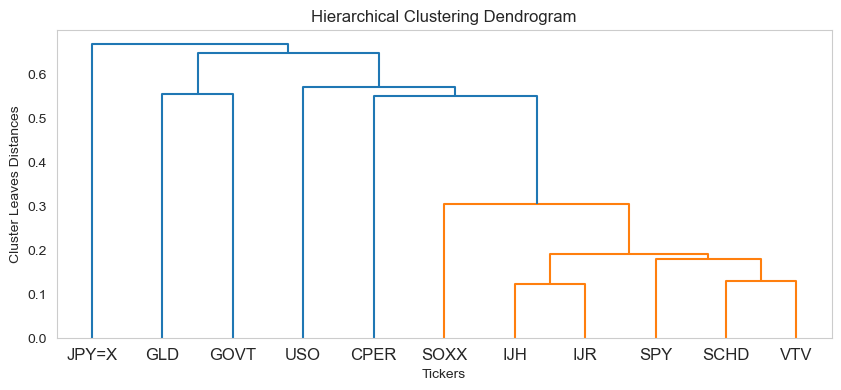

In [6]:
columns = ret_stock_train.columns
plt.figure(figsize = (10, 4))
dendrogram(clusters, labels=columns)
plt.xlabel('Tickers')
plt.ylabel('Cluster Leaves Distances')
plt.grid(False)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

위 Dendogram은 Tree 군집화의 예를 보여주고 있다. 거리는 $\sqrt{\frac{1}{2}(1 - \rho_{i,j})}$로 정의되었음을 유의하자

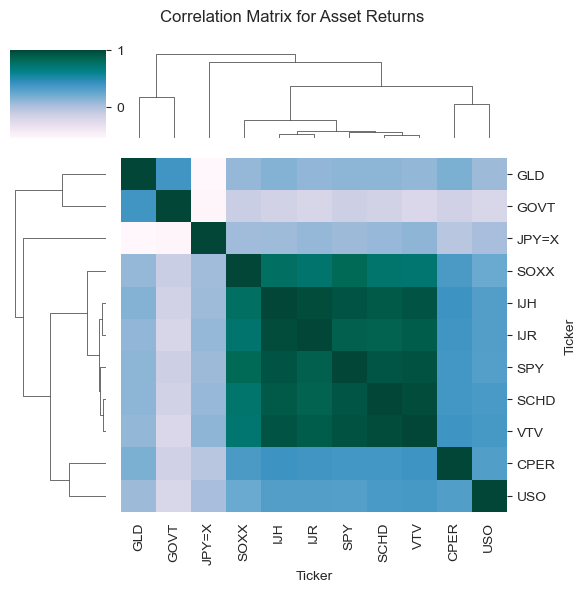

In [7]:
import warnings
warnings.filterwarnings('ignore')

g = sns.clustermap(correlation, figsize = (6, 6), cmap = 'PuBuGn')
g.fig.suptitle('Correlation Matrix for Asset Returns')
plt.tight_layout()
plt.show()

seaborn의 clustermap을 이용하면 간단하게 트리 군집화의 heatmap을 볼 수 있다

#### 준 대각화(Quasi Diagonalization)

이 단계는 공분산 행렬의 행과 열을 재구성해 가장 큰 값이 대각선에 위치하게 한다. 공분산의 준대각화는 유용한 속성이다
유사한 금융 상품은 함께 배치되고 다른 상품은 서로 떨어뜨리도록 배치한다. 알고리즘은 아래의 코드와 같이 작동하는데, 연결 행렬의 각 행이 두 branch를 하나로 합친다는 것을 알고 있다. 가지 내의 군집들을 그 구성 성분으로 재귀적으로 교체하여, 군집이 더이상 남지 않을 때까지 반복한다. 이런 교체는 군집화의 순서를 유지하게 하는데, 출력은 군집화되지 않은 원소의 정렬된 리스트이다. 아래의 예제를 통해 준 대각화에 대해서 간단히 살펴보자

In [8]:
def QuasiDiag(link: np.ndarray) -> list:
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]    # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)    # make space
        df0 = sortIx[sortIx >= numItems]    # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]    # item 1
        df0 = pd.Series(link[j, 1], index=i+1)
        sortIx = pd.concat([sortIx, df0])    # item 2
        sortIx = sortIx.sort_index()    # re-sort
        sortIx.index = range(sortIx.shape[0])    # re-index
    lst =  sortIx.tolist()
    return lst

In [9]:
print(QuasiDiag(clusters)) # 준 대각화된 성분의 index

[5, 1, 2, 9, 0, 7, 3, 4, 8, 6, 10]


#### 재귀적 이분법

우리는 이미 준대각 행렬을 얻었다. 역분산 배분은 대각 공분산 행렬에 대해 최적이다. 이 사실들로부터 두 가지 활용이 가능하다

1. 상향식 : 연속된 부분 집합의 분산을 역분산 배분의 분산으로 정의한다
2. 하향식 : 인접한 부분 집합 간의 배분을 이들의 총 분산에 역으로 비례하도록 분할한다. 아래의 알고리즘은 하향식 아이디어를 공식화한다

In [10]:
def InversePortfolio(cov, **kargs) : 
    ivp = 1 / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def ClusterVar(cov, cItems) :
    cov_ = pd.DataFrame(cov).loc[cItems, cItems] # 행렬 분할
    w_ = InversePortfolio(cov_).reshape(-1, 1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0]
    return cVar

def RecBipart(cov: np.ndarray, sortIx: list) -> pd.Series:
    w = pd.Series([1] * len(sortIx), index=sortIx)
    cItems = [sortIx]    # 모든 아이템을 하나의 군집으로 초기화
    while len(cItems) > 0:
        cItems = [i[int(j): int(k)] for i in cItems
                  for j, k in ((0, len(i) / 2), (len(i) / 2, len(i))) if len(i) > 1]    # bi-section
        for i in range(0, len(cItems), 2):    # parse in pairs
            cItems0 = cItems[i]    # cluster 1
            cItems1 = cItems[i+1]    # cluster 2
            cVar0 = ClusterVar(cov, cItems0)
            cVar1 = ClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha    # weight 1
            w[cItems1] *= 1 - alpha    # weight 2
    return w

In [11]:
Ix = QuasiDiag(clusters)
weights = RecBipart(ret_stock_train.cov().values, Ix)
weights

5     0.265473
1     0.104110
2     0.579780
9     0.005775
0     0.017854
7     0.003903
3     0.003355
4     0.002818
8     0.008153
6     0.004557
10    0.004222
dtype: float64

In [12]:
ret_stock.iloc[:, weights.index].columns

Index(['JPY=X', 'GLD', 'GOVT', 'USO', 'CPER', 'SOXX', 'IJH', 'IJR', 'SPY',
       'SCHD', 'VTV'],
      dtype='object', name='Ticker')

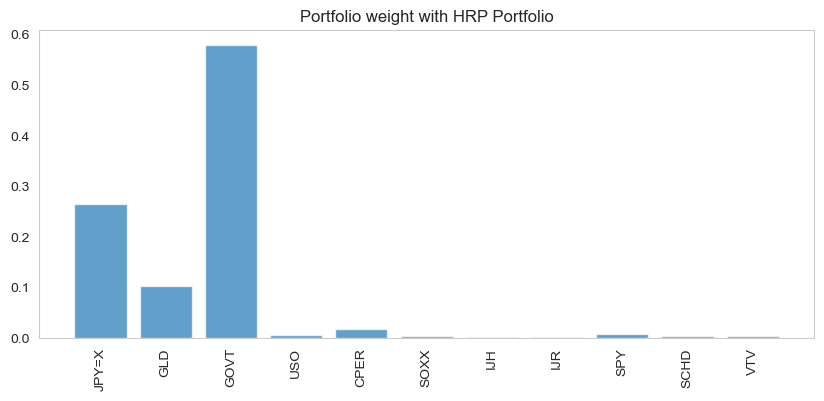

In [13]:
plt.figure(figsize = (10,4))
plt.bar(ret_stock_train.iloc[:, weights.index].columns, weights, alpha = 0.7)
plt.grid(False)
plt.xticks(rotation = 90)
plt.title("Portfolio weight with HRP Portfolio")
plt.show()

추정된 weight를 통해서 test기간 동안의 자산배분을 하면 다음과 같은 성과가 나온다

In [14]:
port_ret = (ret_stock_test * weights.values).sum(axis = 1)
port_idx = (1 + port_ret).cumprod() * 100

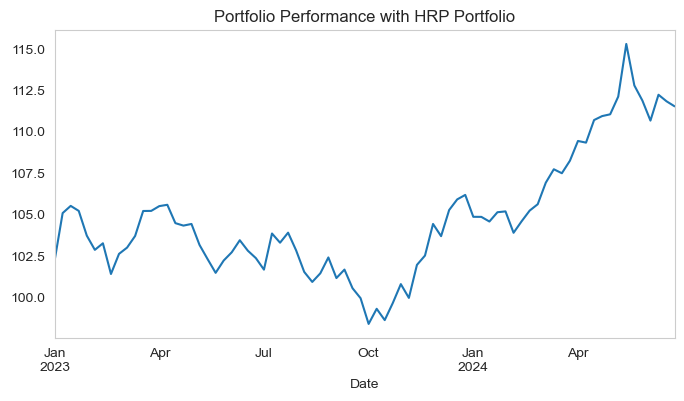

In [15]:
plt.figure(figsize = (8, 4))
port_idx.plot()
plt.grid(False)
plt.title('Portfolio Performance with HRP Portfolio')
plt.show()

### Portfolio Comparison

기존의 배분방법에 비해서 어떤 차이가 있는지 알아보도록 하자

In [16]:
from portfolio_optimization.critical_line_algorithm import CriticalLineAlgorithm

cla = CriticalLineAlgorithm()
cla.allocate(
    asset_names = data.loc[:'2019'].columns, 
    asset_prices = data.loc[:'2019'], 
    resample_by = 'W'
)
cla_weights = cla.weights.sort_values(by = 5, ascending = False, axis = 1)

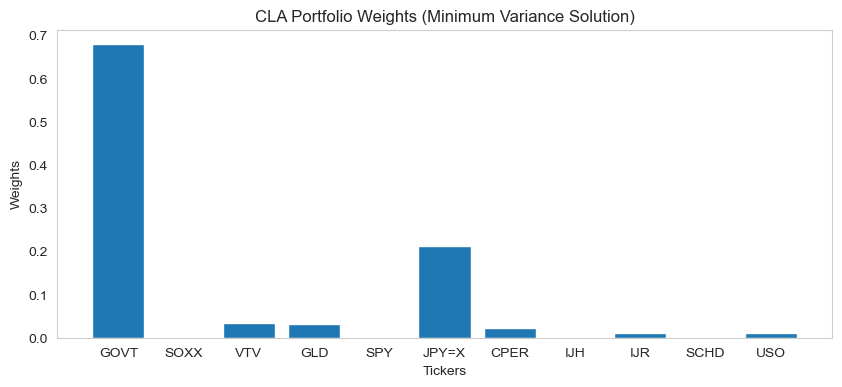

In [18]:
plt.figure(figsize=(10, 4))
plt.bar(cla_weights.columns, cla_weights.values[-1])
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.grid(False)
plt.title('CLA Portfolio Weights (Minimum Variance Solution)')
plt.show()

In [25]:
cla_port = (ret_stock_test * cla_weights.values[-1]).sum(axis = 1)
cla_idx = (1 + cla_port).cumprod() * 100

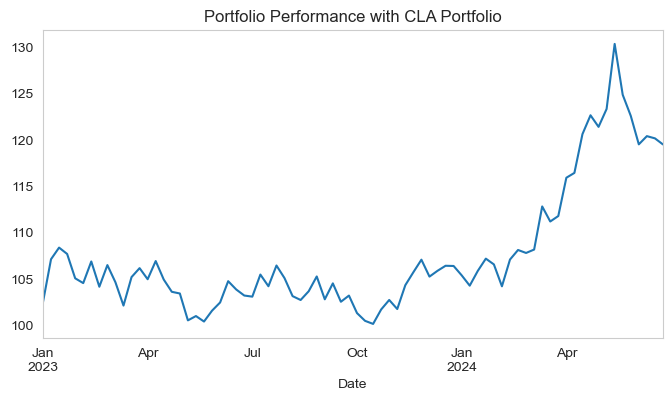

In [27]:
plt.figure(figsize = (8, 4))
cla_idx.plot()
plt.grid(False)
plt.title('Portfolio Performance with CLA Portfolio')
plt.show()

#### IVP allocations

In [28]:
from portfolio_optimization.mean_variance import MeanVarianceOptimisation
mvo = MeanVarianceOptimisation()
mvo.allocate(
    asset_names = data.loc[:'2019'].columns, 
    asset_prices = data.loc[:'2019'], 
    resample_by = 'W'
)
ivp_weights = mvo.weights.sort_values(by = 0, ascending = False, axis = 1)

In [29]:
ivp_weights

Ticker,GOVT,JPY=X,SCHD,SPY,VTV,GLD,IJH,IJR,CPER,SOXX,USO
0,0.566617,0.104517,0.054555,0.05258,0.051155,0.050888,0.042322,0.032159,0.01902,0.017451,0.008736


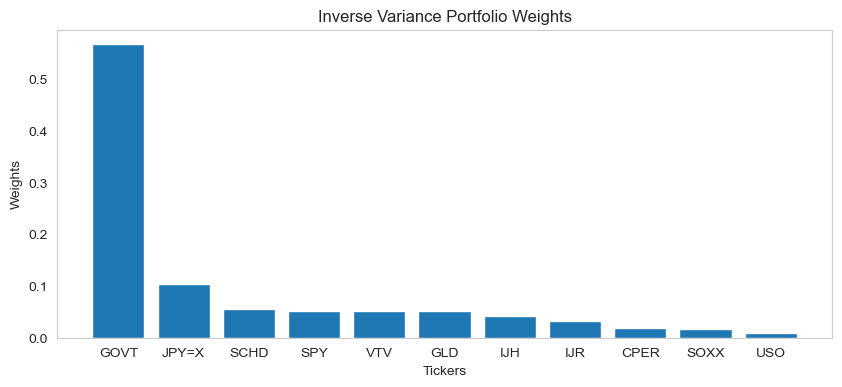

In [30]:
ivp_weights
plt.figure(figsize = (10, 4))
plt.bar(ivp_weights.columns, ivp_weights.values[0])
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.grid(False)
plt.title('Inverse Variance Portfolio Weights')
plt.show()

In [31]:
ivp_port = (ret_stock_test * ivp_weights.values).sum(axis = 1)
ivp_idx = (1 + ivp_port).cumprod() * 100

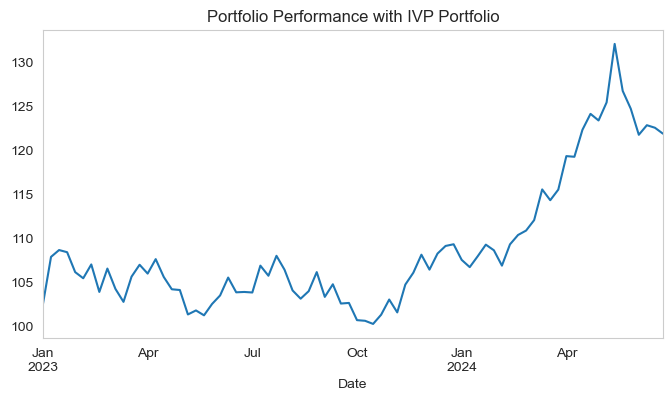

In [32]:
plt.figure(figsize = (8, 4))
ivp_idx.plot()
plt.grid(False)
plt.title('Portfolio Performance with IVP Portfolio')
plt.show()

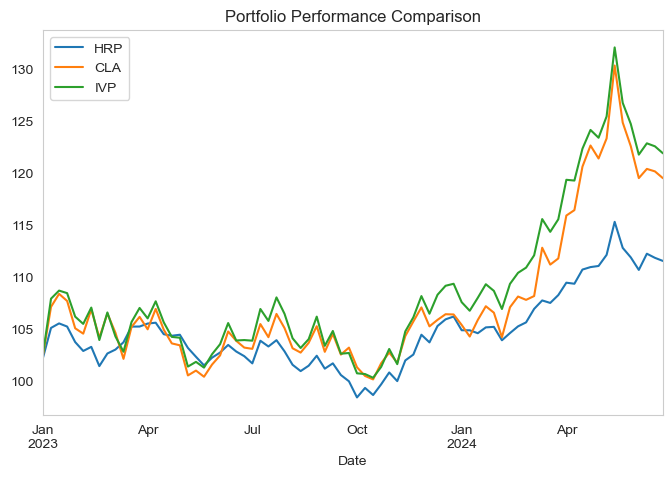

In [36]:
plt.figure(figsize = (8, 5))
port_idx.plot(label = 'HRP')
cla_idx.plot(label = 'CLA')
ivp_idx.plot(label = 'IVP')
plt.legend()
plt.grid(False)
plt.title('Portfolio Performance Comparison')
plt.show()

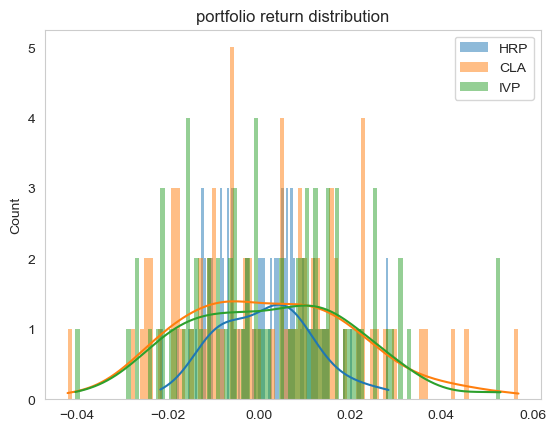

In [40]:
sns.histplot(
    port_ret,
    bins = 100,
    kde = True,
    edgecolor = 'none',
    label = 'HRP'
)
sns.histplot(
    cla_port,
    bins = 100,
    kde = True,
    edgecolor = 'none',
    label = 'CLA'
)
sns.histplot(
    ivp_port,
    bins = 100,
    kde = True,
    edgecolor = 'none',
    label = 'IVP'
)
plt.title('portfolio return distribution')
plt.legend()
plt.grid(False)
plt.show()

HRP는 다른 배분방법에 비해 분산(위험)이 적은 특징을 보인다

In [41]:
print(f'mean of HRP portfolio : {port_ret.mean() : .4f}')
print(f'mean of CLA portfolio : {cla_port.mean() : .4f}')
print(f'mean of IVP portfolio : {ivp_port.mean() : .4f}')

mean of HRP portfolio :  0.0015
mean of CLA portfolio :  0.0025
mean of IVP portfolio :  0.0027


In [42]:
print(f'Standard deviation of HRP portfolio : {port_ret.std() : .4f}')
print(f'Standard deviation of CLA portfolio : {cla_port.std() : .4f}')
print(f'Standard deviation of IVP portfolio : {ivp_port.std() : .4f}')

Standard deviation of HRP portfolio :  0.0106
Standard deviation of CLA portfolio :  0.0191
Standard deviation of IVP portfolio :  0.0187
